In [5]:
import os
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statsmodels.api as sm

In [6]:
frame=pd.read_csv('../FullData/totaldataset.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def strpDateTime(data):
    return data['trx_timestamp'].apply(lambda x : datetime.strptime(x[:10]+x[11:19],"%Y-%m-%d%H:%M:%S"))
def dropCols(data):
    #d_memo and maybe block_num may have some relevance later on
    return data.drop(['account_action_seq','block_num','d_memo','authorization','global_action_seq','data','name','trx_id','trx_timestamp_unix'],axis=1)
def applyLabels(data):
    list_bots=['edgarwinston','Griffinhamza','jacksonjimmy','1ffyqhg4rmbk','1ffyqhg4rmbk','powellernest','2rezoaf4bhly','nckj42dit5sb','scottphillip','oepa252sdx4p','myh2o4wayvxg']
    list_humans=['g44dinjygene','onebrother11','rvrkingfishr','iloveyoudapp','huiyong12345','pketothemoon','zhshj1212123','vipgamedice2','dldldldldldl','pkeniubixxxx']
    data['bot_label']=data['d_from'].apply(lambda x: 1 if x in list_bots else (0 if x in list_humans else None))
def dataProcess(data):
    data['trx_timestamp']=strpDateTime(data)
    data['hours']=[i.hour for i in data['trx_timestamp']]
    data['minutes']=[i.minute for i in data['trx_timestamp']]
    data['seconds']=[i.second for i in data['trx_timestamp']]
    data['day']=[i.day for i in data['trx_timestamp']]
    applyLabels(data)
    return dropCols(data)

In [12]:
def timeseries_agg(data):
    '''
    Pulling together all data on an hourly basis and applying count_txns and volume_eos to it
    @params:
    data is the transaction data set
    
    
    '''
    hour_index=pd.date_range(start="3/1/2019", end="4/1/2019", freq="H")
    timeseries_dummy = pd.DataFrame(0, index=hour_index, columns=['count_txns', 'volume_eos'])
    timeseries_dummy=timeseries_dummy.astype(float)
    for index, row in data.iterrows(): 
        time=row['trx_timestamp'].replace(microsecond=0, second=0, minute=0)
        timeseries_dummy.loc[time]['count_txns']=1+timeseries_dummy.loc[time]['count_txns']
        timeseries_dummy.loc[time]['volume_eos']=row['d_quantity']+ timeseries_dummy.loc[time]['volume_eos']
    return timeseries_dummy
    

In [13]:
def maxAutoCorrelation(data,user):
    '''
    Returns a tuple with maxAutoCorrelation and lag period as values
    '''
    hold=0
    l=0
    data=timeseries_agg(data[data['d_from']==user])
    for i in range(1,168):
        check=data['count_txns'].autocorr(lag=i)
        if (check > hold):
            hold=check
            l=i
    return (hold,l)

In [14]:
def countTotalTransactions(data,account_name):
    return data[data['d_from']==account_name].shape[0]

In [15]:
def getSubSetData(data,low,high):
    user_counts = data['d_from'].value_counts().rename('user_counts')

    zip_data_df = data.merge(user_counts.to_frame(),
                                left_on='d_from',
                                right_index=True)
    return zip_data_df[(zip_data_df['user_counts']>low) & (zip_data_df['user_counts']<high)]

In [16]:
def accountAgg(data):
    list_accounts=data['d_from'].unique()
    dic={}
    dic={el:[0,0] for el in list_accounts}
    for key in dic.keys():
        dic[key][0]=maxAutoCorrelation(data,key)[0]
        dic[key][1]=countTotalTransactions(data,key)
    
    return pd.DataFrame.from_dict(dic,orient='index',columns=['maxAutoCorrelation','numberofTxns']).reset_index()
    

In [9]:
clean_frame=dataProcess(frame)

,account,d_from,d_quantity,d_quantity_unit,d_to,dapp_code,trx_timestamp,hours,minutes,seconds,day,bot_label
0,eosio.token,justiceariel,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:02,0,0,2,7,NaN
1,eosio.token,eossuperplay,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:03,0,0,3,7,NaN
2,eosio.token,nmslnmslnmsl,0.2000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:04,0,0,4,7,NaN
3,eosio.token,edgarwinston,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:06,0,0,6,7,1.0
4,eosio.token,raidenkeegan,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:09,0,0,9,7,NaN
5,eosio.token,endlessdicex,0.0980,EOS,endlessbank1,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
6,eosio.token,endlessdicex,0.0008,EOS,endlessdivdn,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
7,eosio.token,endlessdicex,0.0012,EOS,endlessoptex,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
8,eosio.token,endlessdicex,0.0980,EOS,endlessbank1,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
9,eosio.token,endlessdicex,0.0008,EOS,endlessdivdn,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN


In [93]:
data=accountAgg(getSubSetData(clean_frame,30,200))

In [94]:
def getBotsViaAutoCorrThresh(data):
    names=[]
    for index,row in data.iterrows():
        if row['maxAutoCorrelation']>0.983026:
            names.append(row['index'])
    return names

In [95]:
def applyLabels2(data):
    list_bots=['edgarwinston','1ffyqhg4rmbk','nckj42dit5sb','heathderrick']
    list_bots=list_bots+getBotsViaAutoCorrThresh(data)
    list_humans=['nakajoneso33','myhappyended','bidream3idxx','h4nne5eos231','bobo12341234','praabc123abc']
    data['bot_label']=data['index'].apply(lambda x: 1 if x in list_bots else (0 if x in list_humans else None))

In [96]:
applyLabels2(data)

In [97]:
data

,index,maxAutoCorrelation,numberofTxns,bot_label
0,edgarwinston,0.983027,31,1.0
1,raidenkeegan,0.579704,41,NaN
2,heathderrick,0.983027,31,1.0
3,jakobantoine,0.983027,31,1.0
4,bryantjaylon,0.983027,31,1.0
5,karsonskylar,0.983027,31,1.0
6,luisclarence,0.983027,31,1.0
7,griffinhamza,0.983027,31,1.0
8,miguelmalaki,0.914547,31,NaN
9,devinbeckham,0.983027,31,1.0


In [90]:
#all the accounts with 0.983027 autocorrelation and 31 transactions are all bots

In [38]:
def plot_autocorr_counttxns(data,lagnum):
    plt.subplots(3,0)
    title_name=data['d_from'].iloc[0]
    data=timeseries_agg(data)
    sm.graphics.tsa.plot_acf(data['count_txns'], lags=lagnum)
    plt.title(title_name)
    plt.show()

In [41]:
def selectDataFromUser(data,user):
    return data[data['d_from']==user]

<Figure size 432x288 with 0 Axes>

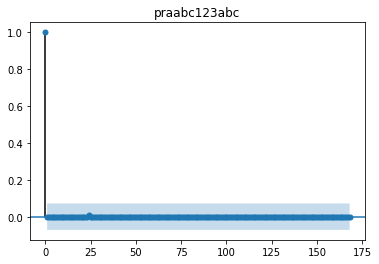

In [86]:
plot_autocorr_counttxns(selectDataFromUser(clean_frame,'praabc123abc'),168)

In [36]:
from sklearn.linear_model import LogisticRegression

In [91]:
log1 = LogisticRegression(random_state=42)

In [100]:
train=data[data['bot_label'].notna()]

In [104]:
train_x=train[['maxAutoCorrelation', 'numberofTxns']]

In [105]:
train_y=train.loc[:, train.columns == 'bot_label']

In [106]:
log1.fit(train_x,train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [108]:
logreg_train_acc = log1.score(train_x,train_y)

In [109]:
print(logreg_train_acc)

0.9529411764705882


In [110]:
unlabeled=data[data['bot_label'].isna()]

In [115]:
unlabeled_x=unlabeled[['maxAutoCorrelation', 'numberofTxns']]

In [116]:
log1.predict(unlabeled_x)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.